# Uplift modelling for Direct Marketing

By Wong Tran

**References**

- [MineThatData E-Mail analytics challenge](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html)
- [Rubin Causal Model](https://en.wikipedia.org/wiki/Rubin_causal_model)
- [Stochastic solutions MineThatData Email Analytics Challenge (2008)](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf)
- [Athey and Imbens (2015)](https://pdfs.semanticscholar.org/86ce/004214845a1683d59b64c4363a067d342cac.pdf)
- [Pylift blog post (2018)](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/)
- [Ascarza (2018)](https://journals.sagepub.com/doi/full/10.1509/jmr.16.0163)
- [Gutierrez and Gerardy (2017)](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)
- [Kunzel et al (2019)](https://arxiv.org/pdf/1706.03461.pdf)
- [Rzepakowski and Jaroszewicz (2012)](https://pdfs.semanticscholar.org/e979/ba084f34345b2ac8783df2b4a3295ae9273f.pdf)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,  train_test_split, GridSearchCV
from scipy.stats import uniform, reciprocal, t
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from uplift.plot_functions import compute_treatment_effect, compute_visit_rates, cumulative_treatment_effect
from uplift.print_ate import *
plt.style.use('fivethirtyeight')

c:\users\wongt\desktop\projects\uplift_modelling\um_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## The data

Data was obtained [here](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html) from the MineThatData E-Mail analytics challenge

In [2]:
df = pd.read_csv("data/hillstrom/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


- **Recency**: Months since last purchase.
- **History_Segment**: Categorization of dollars spent in the past year.
- **History**: Actual dollar value spent in the past year.
- **Mens**: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
- **Womens**: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
- **Zip_Code**: Classifies zip code as Urban, Suburban, or Rural.
- **Newbie**: 1/0 indicator, 1 = New customer in the past twelve months.
- **Channel**: Describes the channels the customer purchased from in the past year.

In [3]:
df.visit.value_counts()

0    54606
1     9394
Name: visit, dtype: int64

In [4]:
df.conversion.value_counts()

0    63422
1      578
Name: conversion, dtype: int64

Only 578 customers made purchases, a rather low conversion rate

## Population average treatment effects of the E-Mail campaign

The population average treatment effect (PATE) of the E-Mail campaign overall is:

$$\tau^{p} = \mathbb E[Y_t - Y_c] =  \mathbb E[Y_t] -  \mathbb E[Y_c]$$

where $Y \in \{ 0, 1 \} $ is equal to $1$ if the customer purchases and $0$ otherwise while $t$ and $c$ indicate the treatment and control groups respectively. 

In a randomized experiment where the E-Mail campaign is randomized across a representative sample of customers, the populatation average treatment effect can be estimated by taking the difference between the average treatment and control group outcomes. This is because, outside of the treatment, the two groups of customers are comparable in terms of their features.

Like for an A/B test, this is what's used to determine whether the E-Mail campaign was a success overall. Was there a (statistically/practically) significant uplift in visits, purchases, or sales as a result of the E-Mail campaign?

In [5]:
visit_rate_ate(df)
print()
conversion_rate_ate(df)
print()
spending_ate(df)

Men's E-Mail visit rate: 18.28%
Women's E-Mail visit rate: 15.14%
Control E-mail visit Rate: 10.62%
---------------------------------
Men's visit rate uplift: 7.66%
Women's visit rate uplift: 4.52%

Men's E-Mail conversion rate: 1.25%
Women's E-Mail conversion rate: 0.88%
Control E-mail conversion Rate: 0.57%
---------------------------------
Men's conversion rate uplift: 0.68%
Women's conversion rate uplift: 0.31%

Men's E-Mail spending: $1.42
Women's E-Mail spending: $1.08
Control E-mail spending: $0.65
---------------------------------
Men's spending uplift: $0.77
Women's spending uplift: $0.42


## Aside - Different formulation

Customers only spend money if they make a purchase (conversion) and they only make a purchase if they visit the website (visit). Therefore a natural way to decompose the uplifts is with the following:

$$\mathbb E[\text{spend}] = \mathbb E[\text{spend|purchase}] \times \text{P}(\text{purchase|visit}) \times \text{P}(\text{visit})$$

In [6]:
spend_given_purchase(df)
print()
purchase_given_visit(df)
print()
visit_rate(df)
print()
spend_per_head(df)

Men's average spend given purchase: $113.53
Women's average spend given purchase: $121.89
Control average spend given purchase: $114.00

Men's purchase rate given visit: 6.86%
Women's purchase rate given visit: 5.84%
Control purchase rate given visit: 5.39%

Men's visit rate: 18.28%
Women's visit rate: 15.14%
Control visit rate: 10.62%

Men's mean spend: $1.42
Women's mean spend: $1.08
Control mean spend: $0.65


## Conditional Average Treatment Effects (CATE)

On average there was an uplift in visit rate and expenditure across the population, however different individuals should react differently to any given intervention. Some customers are more persuadable than others, some will purchase regardless of the E-Mail, whilst others will not purchase regardless of whether they are targeted or not (See section 3 of [this paper](http://stochasticsolutions.com/pdf/CrossSell.pdf)).

To incorporate this type of customer heterogeneity, we instead need to model an individual customer's treatment effect conditional on their features i.e. the conditional average treatment effect (CATE). We are assuming that a customer's features $x$ are predictive of whether or not the E-Mail campaign will have a positive effect on them. 

This is where **uplift modelling** comes in.

We build a model that identifies subpopulations of customers for which the treatment will have the largest uplift. That way we can ensure the largest ROI by only targeting groups of customers that are most likely to respond positively to marketing campaigns.

Mathematically, we target customers whose CATE is larger than the population average treatment effect

$$ \tau^{(i)} = E[ Y_{t}^{(i)} - Y_{c}^{(i)}| \mathbf{x}^{(i)} ] = P( Y^{(i)} | t, \mathbf{x}^{(i)} ) - P( Y^{(i)} | c, \mathbf{x}^{(i)} ) > \tau^{p}$$

where the expecation reduces to probabilities for a binary outcome, and $\mathbf{x^{(i)}}$ is a particular realization of the set of customer features for customer $i$. 

The model will rank customers by uplift in a descending manner and we will investigate the cumulative uplift of the outcome when targeting increasing proportions of the subpopulation from largest to smallest uplift.

## Build Uplift & Response models for Women's Visit Rate

**Methodology**

Perform a 50:50 train/test split where both sets contain treatment and control group customers. The train set will be used to build an uplift model using Pylift (based on the [transformed outcome method](https://pylift.readthedocs.io/en/latest/introduction.html)) and a Response model which will model $P( Y^{(i)} | t, \mathbf{x}^{(i)} )$ with a Random Forest classifier. Then use both models to assign a uplift/response score to the customers in the test set and compare the uplift between the test treatment and test control group customers using a series of plots.

Conversion uplift is not modelled because not enough customers ended up purchasing such that train/test and decile splits resulting in subpopulations <10% of the whole population will have high variances. Uplift for these splits will likely be marginal and not statistically significant and thus modelling conversion uplift requires careful thought and is beyond the scope of this project (see [section 4 and 5](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf) of the best solution to the original challenge)

**Build uplift Model**

In [7]:
womens_df = df[df.segment!='Mens E-Mail'].copy()
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

womens_df.history_segment.replace(hist_seg_map, inplace=True)
# womens_df = pd.get_dummies(womens_df)
zip_code_le, channel_le = LabelEncoder(), LabelEncoder()
womens_df.zip_code = zip_code_le.fit_transform(womens_df.zip_code)
womens_df.channel = channel_le.fit_transform(womens_df.channel)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 18

up1 = TransformedOutcome(womens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=womens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

# up1.randomized_search(
#     param_distributions={
#         'max_depth': range(5,21),
#         'min_samples_split': range(500,7500),
#         'n_estimators': range(3,200),
#         'random_state': [state]
#     },
#     n_iter=300,
#     cv=5,
#     n_jobs=-1,
#     random_state=state
# )
# up1.fit(**up1.rand_search_.best_params_)
# up1.rand_search_.best_params_

best_params = {
    'random_state': state,  # 18
    'n_estimators': 22,
    'min_samples_split': 6079,
    'max_depth': 7
}
up1.fit(**best_params)

**Evaluate uplift model**

Test set visit rate uplift: 4.45%
Qini AUC: 0.01333
Qini AUC: 0.00737


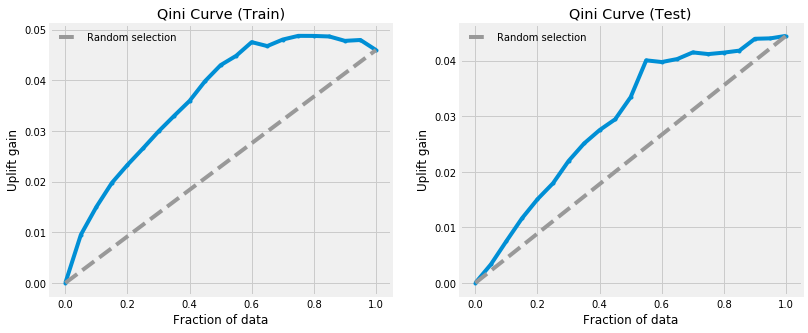

In [8]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up1.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

average_treatment_effect = visit_rate_ate(up1.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up1.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up1.test_results_.Q_qini))

**Build response model**

As mentioned above, the response model predicts $P( Y^{(i)} | t, \mathbf{x}^{(i)} )$ which will also likely give "sure thing" customers (those who will visit the site regardless of being targeted) a high score. This will show up in the plots as test set control group customers having a high visit rate, resulting in a smaller uplift when subtracted from treatment group customer visit rates.

In [9]:
response_train_df = up1.df_train[up1.df_train.Treatment==1].copy()
response_test_df = up1.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    RandomForestClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    iid=False,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]

**Final results df**

In [10]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up1.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up1.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
51797,1,1,81.44,1,0,2,1,1,1,0,0,0.058337,0.002606,"(0.0189, 0.0654]","(-0.0939, 0.00261]"
12084,7,1,29.99,1,0,2,1,1,0,0,-0,0.050909,0.001520,"(0.0189, 0.0654]","(-0.0939, 0.00261]"
32704,2,2,131.86,0,1,1,0,2,1,0,0,0.189546,0.087292,"(0.183, 0.205]","(0.0856, 0.0879]"
46254,9,4,458.48,0,1,1,0,1,0,0,-0,0.182715,0.072999,"(0.16, 0.183]","(0.0662, 0.0752]"
8655,5,2,193.18,0,1,2,0,1,0,0,-0,0.163849,0.075430,"(0.16, 0.183]","(0.0752, 0.0788]"


## Comparison of visit rates between response and uplift model

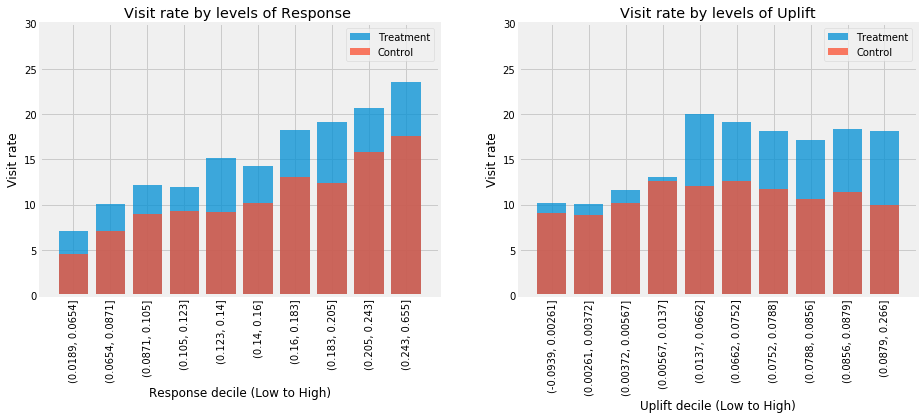

In [11]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

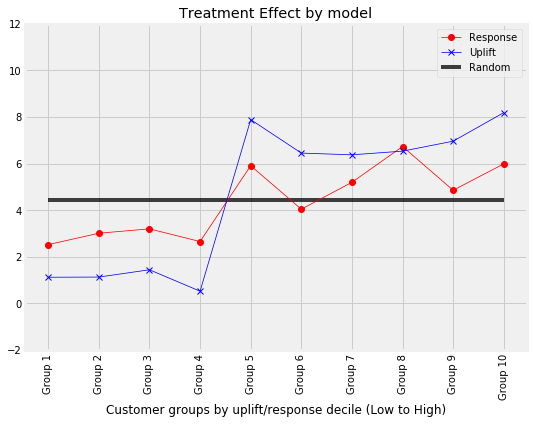

In [12]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect

## Cumulative impact of Direct Marketing campaign

In [13]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)
uplift_cumul_treatment_effect

,treatment_cumul_visit_rate,control_cumul_visit_rate,cumul_treatment_effect,pooled_proportion,standard_error
0,0.181728,0.099808,0.081920,0.140068,0.015336
1,0.182417,0.106704,0.075712,0.144641,0.010797
2,0.178806,0.106557,0.072248,0.142835,0.008768
3,0.179234,0.108999,0.070235,0.144095,0.007706
4,0.181750,0.112837,0.068913,0.147164,0.006866
5,0.184016,0.113738,0.070278,0.148969,0.006466
6,0.176084,0.115531,0.060553,0.145882,0.005911
7,0.170245,0.114155,0.056090,0.142260,0.005558
8,0.158230,0.109806,0.048425,0.134052,0.004931
9,0.152235,0.107763,0.044472,0.130042,0.004604


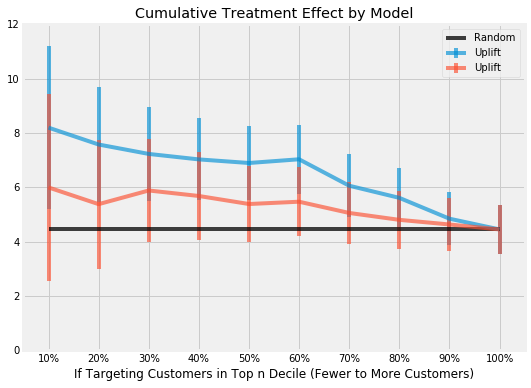

In [14]:
response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)

plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

**Who to target?**

Target the top X deciles depending on marketing budget etc.

In [15]:
results_df['uplift_decile'].value_counts().sort_index(ascending=False).reset_index().\
rename(columns={'uplift_decile': 'number_of_customers', 'index': 'uplift_decile'})

,uplift_decile,number_of_customers
0,"(0.0879, 0.266]",2049
1,"(0.0856, 0.0879]",2196
2,"(0.0788, 0.0856]",2126
3,"(0.0752, 0.0788]",1936
4,"(0.0662, 0.0752]",2341
5,"(0.0137, 0.0662]",1482
6,"(0.00567, 0.0137]",2135
7,"(0.00372, 0.00567]",1537
8,"(0.00261, 0.00372]",3295
9,"(-0.0939, 0.00261]",2250


## Average customer features by uplift decile

Zip code label encodings: ['Rural' 'Surburban' 'Urban']
Channel label encodings: ['Multichannel' 'Phone' 'Web']


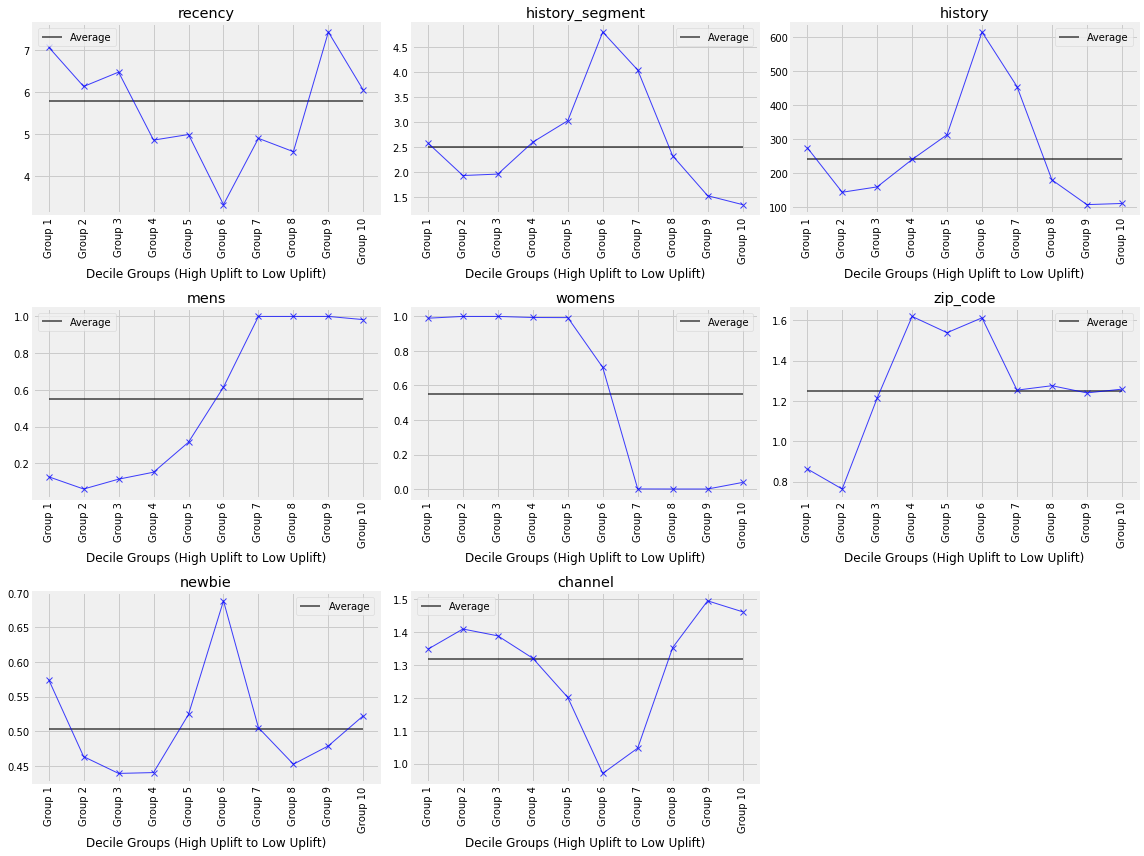

In [16]:
feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

print(f"Zip code label encodings: {zip_code_le.classes_}")
print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(16,12))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(3,3,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout() 

<br>
<br>

## Build Uplift & Response models for Men's Visit Rate

In [17]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
mens_df.drop(columns=['conversion', 'spend'], inplace=True)

hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

mens_df.history_segment.replace(hist_seg_map, inplace=True)
# mens_df = pd.get_dummies(mens_df)
mens_df.zip_code = LabelEncoder().fit_transform(mens_df.zip_code)
mens_df.channel = LabelEncoder().fit_transform(mens_df.channel)
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 10

up2 = TransformedOutcome(mens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=mens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

# up2.randomized_search(
#     param_distributions={
#         'max_depth': range(5,21),
#         'min_samples_split': range(500,7500),
#         'n_estimators': range(3,200),
#         'random_state': [state]
#     },
#     n_iter=300,
#     cv=5,
#     n_jobs=-1,
#     random_state=state
# )
# up2.fit(**up2.rand_search_.best_params_)
# up2.rand_search_.best_params_


best_params = {
    'random_state': 5,
    'n_estimators': 126,
    'max_features': 'sqrt',
    'max_depth': 4
}
up2.fit(**best_params)

**Evaluate uplift model**

Male E-Mail campaign customer features are less predictive of outcome uplift which is consistent with the best solution from the original challenge ([see section 5.3](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf)). The model seems to also have overfit the training set and thus further hyperparameter tuning and model selection may be required. 

Test set visit rate uplift: 7.47%
Qini AUC: 0.01670
Qini AUC: 0.00239


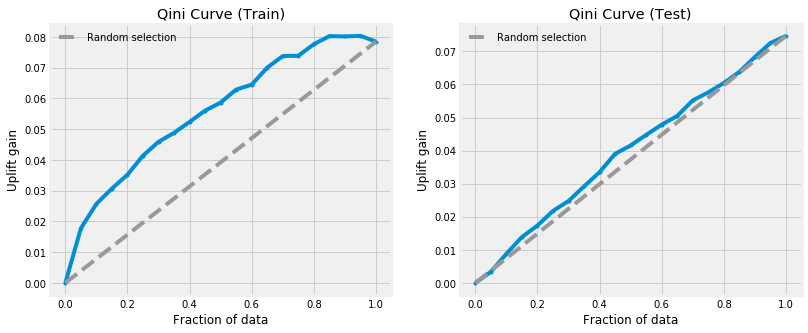

In [18]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up2.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up2.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

average_treatment_effect = visit_rate_ate(up2.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up2.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up2.test_results_.Q_qini))

**Response model**

In [19]:
response_train_df = up2.df_train[up2.df_train.Treatment==1].copy()
response_test_df = up2.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    RandomForestClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    iid=False,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]

**Final results df**

In [20]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up2.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up2.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up2.transformed_y_test_pred, 10)

results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
17206,2,4,487.68,1,1,2,0,0,0,0,-0,0.253158,0.108616,"(0.232, 0.279]","(0.0984, 0.531]"
17465,4,1,86.80,1,0,1,1,1,0,0,-0,0.145537,0.067532,"(0.129, 0.151]","(0.0658, 0.0681]"
54868,9,1,31.28,1,0,0,0,1,0,0,-0,0.169899,0.079240,"(0.168, 0.182]","(0.0774, 0.0826]"
40867,3,1,62.45,1,0,2,1,1,0,0,-0,0.147441,0.070129,"(0.129, 0.151]","(0.0681, 0.0705]"
19014,1,3,269.36,1,0,1,0,1,1,0,0,0.236264,0.087301,"(0.232, 0.279]","(0.0826, 0.0895]"


## Comparison of visit rates between response and uplift model

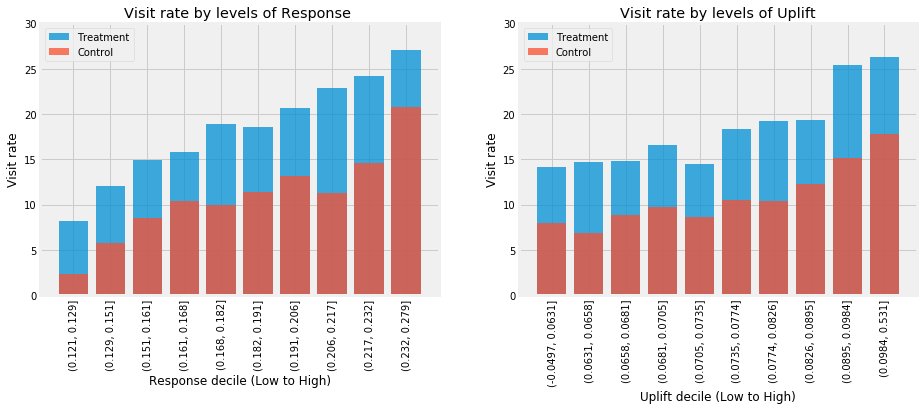

In [21]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

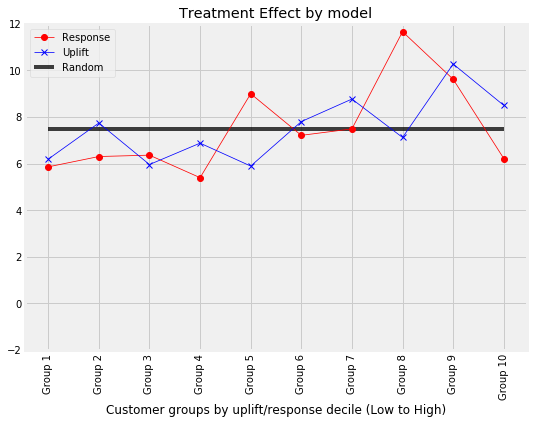

In [22]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect

## Cumulative impact of Direct Marketing campaign

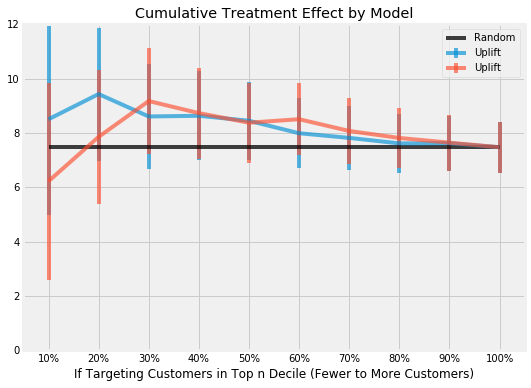

In [23]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)

response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)

plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

## Average customer features by uplift decile

Zip code label encodings: ['Rural' 'Surburban' 'Urban']
Channel label encodings: ['Multichannel' 'Phone' 'Web']


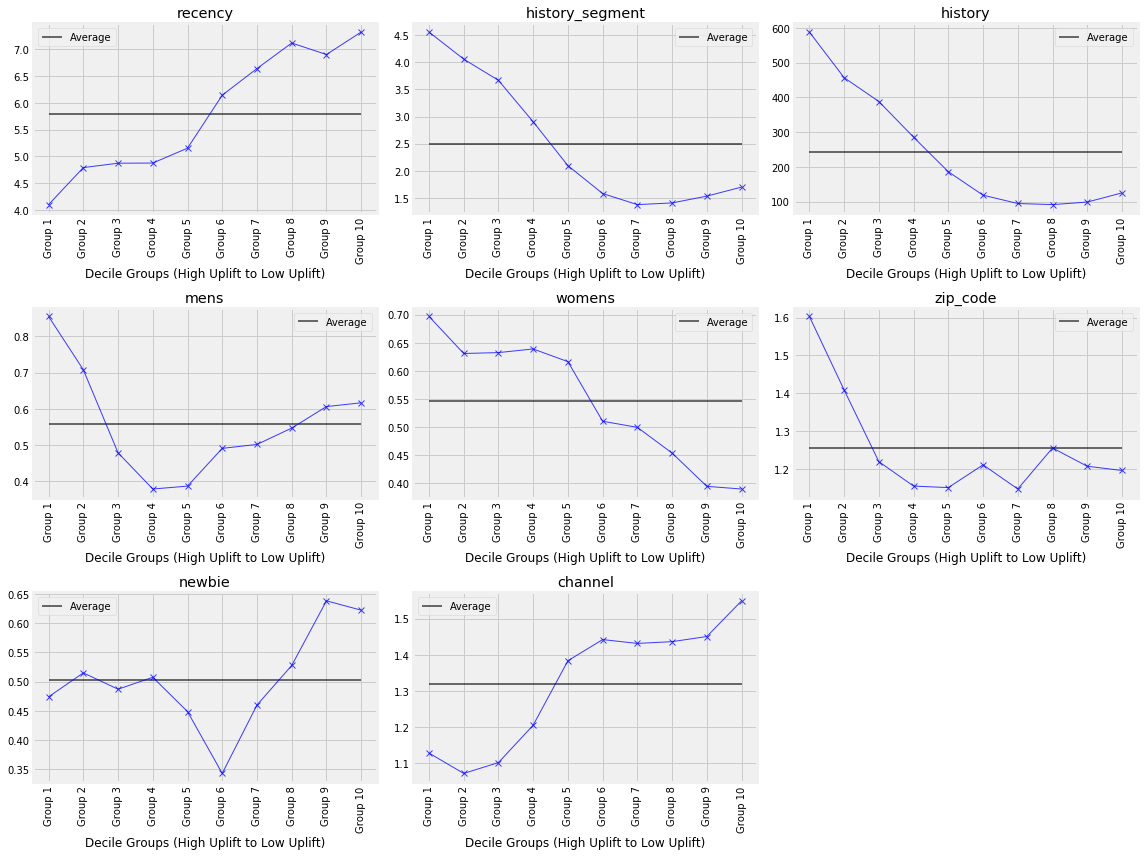

In [24]:
feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

print(f"Zip code label encodings: {zip_code_le.classes_}")
print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(16,12))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(3,3,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout() 